In [1]:
import numpy as np
import torch
import transformers
import matplotlib.pyplot as plt

from transformers import BertConfig
from transformers import get_cosine_schedule_with_warmup
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
from tqdm.auto import tqdm

from models import DiffusionLM
from data_utils import load_rocstories_dataset_and_tokenizer, RocstoriesDataset
from noise_schedule import get_named_beta_schedule
from train_utils import train, evaluate

%matplotlib inline

In [2]:
# dataset args
max_len = 72    # maximum length of input_ids
vocab_threshold = 10    # occurrence time < threshold token as [UNK]
test_size = 0.1     # size of evaluation dataset

# training args
batch_size = 32
device = torch.device("cuda:1")
lr = 2e-4
num_epoch = 50
weight_decay = 0
num_warmup_steps = 100

# model args
word_embedding_dim = 128
hidden_size = 512
num_hidden_layers = 4
num_attention_heads = 8
intermediate_size = 2048
max_position_embeddings = max_len

In [3]:
tokenized_rocstories_dataset, tokenizer = load_rocstories_dataset_and_tokenizer(max_len=max_len, vocab_threshold=vocab_threshold)

rev_tokenizer = {v: k for k, v in tokenizer.items()}

No config specified, defaulting to: roc_stories/all
Reusing dataset roc_stories (/home/dingyizhou/.cache/huggingface/datasets/wza___roc_stories/all/2.1.0/43e2851d9f31e08e4b2dd07a8057ed7a64cbb25cc7105d09856c14e638695506)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/98161 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?ba/s]

In [4]:
train_set, eval_set = train_test_split(tokenized_rocstories_dataset, test_size=test_size, shuffle=True)

train_dataset = RocstoriesDataset(data_lst=train_set['input_ids'], attention_mask_lst=train_set['attention_mask'])
print("Training set size:",len(train_dataset))
eval_dataset = RocstoriesDataset(data_lst=eval_set['input_ids'], attention_mask_lst=eval_set['attention_mask'])
print("Evaluation set size:", len(eval_dataset))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)

Training set size: 88344
Evaluation set size: 9817


In [5]:
config = BertConfig(vocab_size=len(tokenizer), hidden_size=hidden_size, num_hidden_layers=num_hidden_layers, num_attention_heads=num_attention_heads, intermediate_size=intermediate_size, max_position_embeddings=max_position_embeddings, pad_token_id=tokenizer['[PAD]'])

config.T = 2000
config.word_embedding_dim = word_embedding_dim

print(config)

BertConfig {
  "T": 2000,
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 2048,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 72,
  "model_type": "bert",
  "num_attention_heads": 8,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 11831,
  "word_embedding_dim": 128
}



In [6]:
betas = torch.Tensor(get_named_beta_schedule(schedule_name="sqrt", num_diffusion_timesteps=config.T))

In [7]:
diffusion_model = DiffusionLM(config=config, betas=betas, use_attention_mask=False, use_shared_weight=False, add_emb_noise=True).to(device)

print("Diffusion model #parameters:")
print(sum([p.numel() for p in diffusion_model.parameters()]))

Diffusion model #parameters:
17369015


In [8]:
optimizer = torch.optim.AdamW(diffusion_model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = get_cosine_schedule_with_warmup(optimizer=optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_epoch*len(train_dataloader))

In [9]:
loss_terms_dict_lst = []
loss_terms_weights = {'mse':1, 'L_T':1, 'rounding': 1}
progress_bar = tqdm(range(num_epoch*len(train_dataloader)))

for epoch in range(num_epoch):
    print("epoch:",epoch+1)
    loss_terms_dict_lst.append(train(diffusion_model=diffusion_model, dataloader=train_dataloader, optimizer=optimizer, scheduler=scheduler ,progress_bar=progress_bar, loss_terms_weights=loss_terms_weights ,verbose=True))
    evaluate(diffusion_model=diffusion_model, dataloader=eval_dataloader, loss_terms_weights=loss_terms_weights)

  0%|          | 0/138050 [00:00<?, ?it/s]

epoch: 1
step: 100
mse  training loss=0.8261
L_T  training loss=0.0000
rounding  training loss=9.0203
step: 200
mse  training loss=0.5848
L_T  training loss=0.0000
rounding  training loss=7.2288
step: 300
mse  training loss=0.4985
L_T  training loss=0.0000
rounding  training loss=5.1360
step: 400
mse  training loss=0.4493
L_T  training loss=0.0000
rounding  training loss=3.4085
step: 500
mse  training loss=0.4211
L_T  training loss=0.0000
rounding  training loss=2.3304
step: 600
mse  training loss=0.3963
L_T  training loss=0.0000
rounding  training loss=1.7090
step: 700
mse  training loss=0.3929
L_T  training loss=0.0000
rounding  training loss=1.3688
step: 800
mse  training loss=0.3707
L_T  training loss=0.0000
rounding  training loss=1.1454
step: 900
mse  training loss=0.3646
L_T  training loss=0.0000
rounding  training loss=0.9873
step: 1000
mse  training loss=0.3515
L_T  training loss=0.0000
rounding  training loss=0.8733
step: 1100
mse  training loss=0.3384
L_T  training loss=0.00

  0%|          | 0/307 [00:00<?, ?it/s]

eval loss=0.4686
epoch: 2
step: 100
mse  training loss=0.2582
L_T  training loss=0.0000
rounding  training loss=0.2154
step: 200
mse  training loss=0.2602
L_T  training loss=0.0000
rounding  training loss=0.2033
step: 300
mse  training loss=0.2609
L_T  training loss=0.0000
rounding  training loss=0.1945
step: 400
mse  training loss=0.2569
L_T  training loss=0.0000
rounding  training loss=0.1798
step: 500
mse  training loss=0.2528
L_T  training loss=0.0000
rounding  training loss=0.1702
step: 600
mse  training loss=0.2525
L_T  training loss=0.0000
rounding  training loss=0.1668
step: 700
mse  training loss=0.2451
L_T  training loss=0.0000
rounding  training loss=0.1573
step: 800
mse  training loss=0.2443
L_T  training loss=0.0000
rounding  training loss=0.1509
step: 900
mse  training loss=0.2484
L_T  training loss=0.0000
rounding  training loss=0.1451
step: 1000
mse  training loss=0.2409
L_T  training loss=0.0000
rounding  training loss=0.1399
step: 1100
mse  training loss=0.2513
L_T  t

  0%|          | 0/307 [00:00<?, ?it/s]

eval loss=0.2783
epoch: 3
step: 100
mse  training loss=0.2262
L_T  training loss=0.0000
rounding  training loss=0.0593
step: 200
mse  training loss=0.2246
L_T  training loss=0.0000
rounding  training loss=0.0586
step: 300
mse  training loss=0.2217
L_T  training loss=0.0000
rounding  training loss=0.0550
step: 400
mse  training loss=0.2180
L_T  training loss=0.0000
rounding  training loss=0.0532
step: 500
mse  training loss=0.2181
L_T  training loss=0.0000
rounding  training loss=0.0517
step: 600
mse  training loss=0.2213
L_T  training loss=0.0000
rounding  training loss=0.0497
step: 700
mse  training loss=0.2110
L_T  training loss=0.0000
rounding  training loss=0.0473
step: 800
mse  training loss=0.2150
L_T  training loss=0.0000
rounding  training loss=0.0481
step: 900
mse  training loss=0.2145
L_T  training loss=0.0000
rounding  training loss=0.0445
step: 1000
mse  training loss=0.2185
L_T  training loss=0.0000
rounding  training loss=0.0441
step: 1100
mse  training loss=0.2084
L_T  t

  0%|          | 0/307 [00:00<?, ?it/s]

eval loss=0.2164
epoch: 4
step: 100
mse  training loss=0.2016
L_T  training loss=0.0000
rounding  training loss=0.0206
step: 200
mse  training loss=0.1990
L_T  training loss=0.0000
rounding  training loss=0.0194
step: 300
mse  training loss=0.1993
L_T  training loss=0.0000
rounding  training loss=0.0187
step: 400
mse  training loss=0.1960
L_T  training loss=0.0000
rounding  training loss=0.0177
step: 500
mse  training loss=0.2017
L_T  training loss=0.0000
rounding  training loss=0.0172
step: 600
mse  training loss=0.1964
L_T  training loss=0.0000
rounding  training loss=0.0160
step: 700
mse  training loss=0.1936
L_T  training loss=0.0000
rounding  training loss=0.0169
step: 800
mse  training loss=0.1934
L_T  training loss=0.0000
rounding  training loss=0.0151
step: 900
mse  training loss=0.1941
L_T  training loss=0.0000
rounding  training loss=0.0151
step: 1000
mse  training loss=0.1929
L_T  training loss=0.0000
rounding  training loss=0.0145
step: 1100
mse  training loss=0.1882
L_T  t

  0%|          | 0/307 [00:00<?, ?it/s]

eval loss=0.1830
epoch: 5
step: 100
mse  training loss=0.1812
L_T  training loss=0.0000
rounding  training loss=0.0065
step: 200
mse  training loss=0.1827
L_T  training loss=0.0000
rounding  training loss=0.0060
step: 300
mse  training loss=0.1818
L_T  training loss=0.0000
rounding  training loss=0.0064
step: 400
mse  training loss=0.1828
L_T  training loss=0.0000
rounding  training loss=0.0062
step: 500
mse  training loss=0.1749
L_T  training loss=0.0000
rounding  training loss=0.0064
step: 600
mse  training loss=0.1782
L_T  training loss=0.0000
rounding  training loss=0.0058
step: 700
mse  training loss=0.1811
L_T  training loss=0.0000
rounding  training loss=0.0052
step: 800
mse  training loss=0.1779
L_T  training loss=0.0000
rounding  training loss=0.0059
step: 900
mse  training loss=0.1797
L_T  training loss=0.0000
rounding  training loss=0.0057
step: 1000
mse  training loss=0.1804
L_T  training loss=0.0000
rounding  training loss=0.0053
step: 1100
mse  training loss=0.1767
L_T  t

  0%|          | 0/307 [00:00<?, ?it/s]

eval loss=0.1683
epoch: 6
step: 100
mse  training loss=0.1708
L_T  training loss=0.0000
rounding  training loss=0.0023
step: 200
mse  training loss=0.1700
L_T  training loss=0.0000
rounding  training loss=0.0024
step: 300
mse  training loss=0.1699
L_T  training loss=0.0000
rounding  training loss=0.0023
step: 400
mse  training loss=0.1698
L_T  training loss=0.0000
rounding  training loss=0.0021
step: 500
mse  training loss=0.1703
L_T  training loss=0.0000
rounding  training loss=0.0024
step: 600
mse  training loss=0.1683
L_T  training loss=0.0000
rounding  training loss=0.0021
step: 700
mse  training loss=0.1653
L_T  training loss=0.0000
rounding  training loss=0.0021
step: 800
mse  training loss=0.1702
L_T  training loss=0.0000
rounding  training loss=0.0018
step: 900
mse  training loss=0.1657
L_T  training loss=0.0000
rounding  training loss=0.0019
step: 1000
mse  training loss=0.1677
L_T  training loss=0.0000
rounding  training loss=0.0022
step: 1100
mse  training loss=0.1714
L_T  t

  0%|          | 0/307 [00:00<?, ?it/s]

eval loss=0.1539
epoch: 7
step: 100
mse  training loss=0.1558
L_T  training loss=0.0000
rounding  training loss=0.0011
step: 200
mse  training loss=0.1544
L_T  training loss=0.0000
rounding  training loss=0.0011
step: 300
mse  training loss=0.1593
L_T  training loss=0.0000
rounding  training loss=0.0011
step: 400
mse  training loss=0.1603
L_T  training loss=0.0000
rounding  training loss=0.0011
step: 500
mse  training loss=0.1535
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 600
mse  training loss=0.1559
L_T  training loss=0.0000
rounding  training loss=0.0011
step: 700
mse  training loss=0.1551
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 800
mse  training loss=0.1543
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 900
mse  training loss=0.1552
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 1000
mse  training loss=0.1540
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 1100
mse  training loss=0.1504
L_T  t

  0%|          | 0/307 [00:00<?, ?it/s]

eval loss=0.1426
epoch: 8
step: 100
mse  training loss=0.1470
L_T  training loss=0.0000
rounding  training loss=0.0004
step: 200
mse  training loss=0.1456
L_T  training loss=0.0000
rounding  training loss=0.0005
step: 300
mse  training loss=0.1480
L_T  training loss=0.0000
rounding  training loss=0.0005
step: 400
mse  training loss=0.1465
L_T  training loss=0.0000
rounding  training loss=0.0005
step: 500
mse  training loss=0.1446
L_T  training loss=0.0000
rounding  training loss=0.0005
step: 600
mse  training loss=0.1447
L_T  training loss=0.0000
rounding  training loss=0.0006
step: 700
mse  training loss=0.1454
L_T  training loss=0.0000
rounding  training loss=0.0005
step: 800
mse  training loss=0.1455
L_T  training loss=0.0000
rounding  training loss=0.0004
step: 900
mse  training loss=0.1427
L_T  training loss=0.0000
rounding  training loss=0.0003
step: 1000
mse  training loss=0.1432
L_T  training loss=0.0000
rounding  training loss=0.0005
step: 1100
mse  training loss=0.1449
L_T  t

  0%|          | 0/307 [00:00<?, ?it/s]

eval loss=0.1325
epoch: 9
step: 100
mse  training loss=0.1348
L_T  training loss=0.0000
rounding  training loss=0.0003
step: 200
mse  training loss=0.1338
L_T  training loss=0.0000
rounding  training loss=0.0003
step: 300
mse  training loss=0.1353
L_T  training loss=0.0000
rounding  training loss=0.0003
step: 400
mse  training loss=0.1356
L_T  training loss=0.0000
rounding  training loss=0.0002
step: 500
mse  training loss=0.1321
L_T  training loss=0.0000
rounding  training loss=0.0002
step: 600
mse  training loss=0.1334
L_T  training loss=0.0000
rounding  training loss=0.0003
step: 700
mse  training loss=0.1313
L_T  training loss=0.0000
rounding  training loss=0.0002
step: 800
mse  training loss=0.1341
L_T  training loss=0.0000
rounding  training loss=0.0002
step: 900
mse  training loss=0.1298
L_T  training loss=0.0000
rounding  training loss=0.0002
step: 1000
mse  training loss=0.1330
L_T  training loss=0.0000
rounding  training loss=0.0002
step: 1100
mse  training loss=0.1302
L_T  t

  0%|          | 0/307 [00:00<?, ?it/s]

eval loss=0.1216
epoch: 10
step: 100
mse  training loss=0.1263
L_T  training loss=0.0000
rounding  training loss=0.0002
step: 200
mse  training loss=0.1270
L_T  training loss=0.0000
rounding  training loss=0.0002
step: 300
mse  training loss=0.1206
L_T  training loss=0.0000
rounding  training loss=0.0002
step: 400
mse  training loss=0.1210
L_T  training loss=0.0000
rounding  training loss=0.0002
step: 500
mse  training loss=0.1207
L_T  training loss=0.0000
rounding  training loss=0.0002
step: 600
mse  training loss=0.1233
L_T  training loss=0.0000
rounding  training loss=0.0002
step: 700
mse  training loss=0.1219
L_T  training loss=0.0000
rounding  training loss=0.0002
step: 800
mse  training loss=0.1195
L_T  training loss=0.0000
rounding  training loss=0.0002
step: 900
mse  training loss=0.1223
L_T  training loss=0.0000
rounding  training loss=0.0002
step: 1000
mse  training loss=0.1187
L_T  training loss=0.0000
rounding  training loss=0.0002
step: 1100
mse  training loss=0.1201
L_T  

  0%|          | 0/307 [00:00<?, ?it/s]

eval loss=0.1075
epoch: 11
step: 100
mse  training loss=0.1083
L_T  training loss=0.0000
rounding  training loss=0.0003
step: 200
mse  training loss=0.1115
L_T  training loss=0.0000
rounding  training loss=0.0002
step: 300
mse  training loss=0.1098
L_T  training loss=0.0000
rounding  training loss=0.0003
step: 400
mse  training loss=0.1091
L_T  training loss=0.0000
rounding  training loss=0.0003
step: 500
mse  training loss=0.1092
L_T  training loss=0.0000
rounding  training loss=0.0003
step: 600
mse  training loss=0.1076
L_T  training loss=0.0000
rounding  training loss=0.0003
step: 700
mse  training loss=0.1089
L_T  training loss=0.0000
rounding  training loss=0.0003
step: 800
mse  training loss=0.1056
L_T  training loss=0.0000
rounding  training loss=0.0003
step: 900
mse  training loss=0.1090
L_T  training loss=0.0000
rounding  training loss=0.0003
step: 1000
mse  training loss=0.1065
L_T  training loss=0.0000
rounding  training loss=0.0003
step: 1100
mse  training loss=0.1078
L_T  

  0%|          | 0/307 [00:00<?, ?it/s]

eval loss=0.0958
epoch: 12
step: 100
mse  training loss=0.0966
L_T  training loss=0.0000
rounding  training loss=0.0005
step: 200
mse  training loss=0.0968
L_T  training loss=0.0000
rounding  training loss=0.0005
step: 300
mse  training loss=0.0964
L_T  training loss=0.0000
rounding  training loss=0.0005
step: 400
mse  training loss=0.0942
L_T  training loss=0.0000
rounding  training loss=0.0005
step: 500
mse  training loss=0.0944
L_T  training loss=0.0000
rounding  training loss=0.0005
step: 600
mse  training loss=0.0954
L_T  training loss=0.0000
rounding  training loss=0.0005
step: 700
mse  training loss=0.0941
L_T  training loss=0.0000
rounding  training loss=0.0005
step: 800
mse  training loss=0.0922
L_T  training loss=0.0000
rounding  training loss=0.0005
step: 900
mse  training loss=0.0924
L_T  training loss=0.0000
rounding  training loss=0.0006
step: 1000
mse  training loss=0.0927
L_T  training loss=0.0000
rounding  training loss=0.0006
step: 1100
mse  training loss=0.0926
L_T  

  0%|          | 0/307 [00:00<?, ?it/s]

eval loss=0.0829
epoch: 13
step: 100
mse  training loss=0.0832
L_T  training loss=0.0000
rounding  training loss=0.0007
step: 200
mse  training loss=0.0824
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 300
mse  training loss=0.0824
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 400
mse  training loss=0.0812
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 500
mse  training loss=0.0806
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 600
mse  training loss=0.0805
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 700
mse  training loss=0.0798
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 800
mse  training loss=0.0779
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 900
mse  training loss=0.0790
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 1000
mse  training loss=0.0779
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 1100
mse  training loss=0.0766
L_T  

  0%|          | 0/307 [00:00<?, ?it/s]

eval loss=0.0710
epoch: 14
step: 100
mse  training loss=0.0700
L_T  training loss=0.0000
rounding  training loss=0.0011
step: 200
mse  training loss=0.0709
L_T  training loss=0.0000
rounding  training loss=0.0011
step: 300
mse  training loss=0.0702
L_T  training loss=0.0000
rounding  training loss=0.0011
step: 400
mse  training loss=0.0704
L_T  training loss=0.0000
rounding  training loss=0.0011
step: 500
mse  training loss=0.0690
L_T  training loss=0.0000
rounding  training loss=0.0011
step: 600
mse  training loss=0.0697
L_T  training loss=0.0000
rounding  training loss=0.0012
step: 700
mse  training loss=0.0690
L_T  training loss=0.0000
rounding  training loss=0.0011
step: 800
mse  training loss=0.0692
L_T  training loss=0.0000
rounding  training loss=0.0011
step: 900
mse  training loss=0.0687
L_T  training loss=0.0000
rounding  training loss=0.0012
step: 1000
mse  training loss=0.0681
L_T  training loss=0.0000
rounding  training loss=0.0012
step: 1100
mse  training loss=0.0671
L_T  

  0%|          | 0/307 [00:00<?, ?it/s]

eval loss=0.0624
epoch: 15
step: 100
mse  training loss=0.0618
L_T  training loss=0.0000
rounding  training loss=0.0013
step: 200
mse  training loss=0.0621
L_T  training loss=0.0000
rounding  training loss=0.0013
step: 300
mse  training loss=0.0609
L_T  training loss=0.0000
rounding  training loss=0.0013
step: 400
mse  training loss=0.0607
L_T  training loss=0.0000
rounding  training loss=0.0012
step: 500
mse  training loss=0.0612
L_T  training loss=0.0000
rounding  training loss=0.0013
step: 600
mse  training loss=0.0608
L_T  training loss=0.0000
rounding  training loss=0.0013
step: 700
mse  training loss=0.0598
L_T  training loss=0.0000
rounding  training loss=0.0013
step: 800
mse  training loss=0.0612
L_T  training loss=0.0000
rounding  training loss=0.0013
step: 900
mse  training loss=0.0600
L_T  training loss=0.0000
rounding  training loss=0.0013
step: 1000
mse  training loss=0.0600
L_T  training loss=0.0000
rounding  training loss=0.0013
step: 1100
mse  training loss=0.0600
L_T  

  0%|          | 0/307 [00:00<?, ?it/s]

eval loss=0.0572
epoch: 16
step: 100
mse  training loss=0.0561
L_T  training loss=0.0000
rounding  training loss=0.0013
step: 200
mse  training loss=0.0556
L_T  training loss=0.0000
rounding  training loss=0.0013
step: 300
mse  training loss=0.0557
L_T  training loss=0.0000
rounding  training loss=0.0013
step: 400
mse  training loss=0.0553
L_T  training loss=0.0000
rounding  training loss=0.0013
step: 500
mse  training loss=0.0551
L_T  training loss=0.0000
rounding  training loss=0.0013
step: 600
mse  training loss=0.0554
L_T  training loss=0.0000
rounding  training loss=0.0013
step: 700
mse  training loss=0.0550
L_T  training loss=0.0000
rounding  training loss=0.0013
step: 800
mse  training loss=0.0555
L_T  training loss=0.0000
rounding  training loss=0.0014
step: 900
mse  training loss=0.0549
L_T  training loss=0.0000
rounding  training loss=0.0013
step: 1000
mse  training loss=0.0538
L_T  training loss=0.0000
rounding  training loss=0.0013
step: 1100
mse  training loss=0.0537
L_T  

  0%|          | 0/307 [00:00<?, ?it/s]

eval loss=0.0521
epoch: 17
step: 100
mse  training loss=0.0515
L_T  training loss=0.0000
rounding  training loss=0.0013
step: 200
mse  training loss=0.0505
L_T  training loss=0.0000
rounding  training loss=0.0013
step: 300
mse  training loss=0.0509
L_T  training loss=0.0000
rounding  training loss=0.0013
step: 400
mse  training loss=0.0514
L_T  training loss=0.0000
rounding  training loss=0.0013
step: 500
mse  training loss=0.0510
L_T  training loss=0.0000
rounding  training loss=0.0013
step: 600
mse  training loss=0.0511
L_T  training loss=0.0000
rounding  training loss=0.0013
step: 700
mse  training loss=0.0498
L_T  training loss=0.0000
rounding  training loss=0.0013
step: 800
mse  training loss=0.0504
L_T  training loss=0.0000
rounding  training loss=0.0013
step: 900
mse  training loss=0.0501
L_T  training loss=0.0000
rounding  training loss=0.0013
step: 1000
mse  training loss=0.0500
L_T  training loss=0.0000
rounding  training loss=0.0013
step: 1100
mse  training loss=0.0506
L_T  

  0%|          | 0/307 [00:00<?, ?it/s]

eval loss=0.0481
epoch: 18
step: 100
mse  training loss=0.0474
L_T  training loss=0.0000
rounding  training loss=0.0013
step: 200
mse  training loss=0.0471
L_T  training loss=0.0000
rounding  training loss=0.0013
step: 300
mse  training loss=0.0472
L_T  training loss=0.0000
rounding  training loss=0.0013
step: 400
mse  training loss=0.0471
L_T  training loss=0.0000
rounding  training loss=0.0013
step: 500
mse  training loss=0.0465
L_T  training loss=0.0000
rounding  training loss=0.0013
step: 600
mse  training loss=0.0466
L_T  training loss=0.0000
rounding  training loss=0.0013
step: 700
mse  training loss=0.0465
L_T  training loss=0.0000
rounding  training loss=0.0013
step: 800
mse  training loss=0.0463
L_T  training loss=0.0000
rounding  training loss=0.0013
step: 900
mse  training loss=0.0462
L_T  training loss=0.0000
rounding  training loss=0.0013
step: 1000
mse  training loss=0.0462
L_T  training loss=0.0000
rounding  training loss=0.0013
step: 1100
mse  training loss=0.0459
L_T  

  0%|          | 0/307 [00:00<?, ?it/s]

eval loss=0.0451
epoch: 19
step: 100
mse  training loss=0.0440
L_T  training loss=0.0000
rounding  training loss=0.0013
step: 200
mse  training loss=0.0444
L_T  training loss=0.0000
rounding  training loss=0.0013
step: 300
mse  training loss=0.0440
L_T  training loss=0.0000
rounding  training loss=0.0013
step: 400
mse  training loss=0.0444
L_T  training loss=0.0000
rounding  training loss=0.0013
step: 500
mse  training loss=0.0439
L_T  training loss=0.0000
rounding  training loss=0.0013
step: 600
mse  training loss=0.0435
L_T  training loss=0.0000
rounding  training loss=0.0012
step: 700
mse  training loss=0.0436
L_T  training loss=0.0000
rounding  training loss=0.0013
step: 800
mse  training loss=0.0434
L_T  training loss=0.0000
rounding  training loss=0.0013
step: 900
mse  training loss=0.0434
L_T  training loss=0.0000
rounding  training loss=0.0012
step: 1000
mse  training loss=0.0428
L_T  training loss=0.0000
rounding  training loss=0.0012
step: 1100
mse  training loss=0.0432
L_T  

  0%|          | 0/307 [00:00<?, ?it/s]

eval loss=0.0432
epoch: 20
step: 100
mse  training loss=0.0419
L_T  training loss=0.0000
rounding  training loss=0.0012
step: 200
mse  training loss=0.0415
L_T  training loss=0.0000
rounding  training loss=0.0012
step: 300
mse  training loss=0.0417
L_T  training loss=0.0000
rounding  training loss=0.0012
step: 400
mse  training loss=0.0417
L_T  training loss=0.0000
rounding  training loss=0.0012
step: 500
mse  training loss=0.0415
L_T  training loss=0.0000
rounding  training loss=0.0012
step: 600
mse  training loss=0.0411
L_T  training loss=0.0000
rounding  training loss=0.0012
step: 700
mse  training loss=0.0412
L_T  training loss=0.0000
rounding  training loss=0.0012
step: 800
mse  training loss=0.0412
L_T  training loss=0.0000
rounding  training loss=0.0012
step: 900
mse  training loss=0.0416
L_T  training loss=0.0000
rounding  training loss=0.0012
step: 1000
mse  training loss=0.0411
L_T  training loss=0.0000
rounding  training loss=0.0012
step: 1100
mse  training loss=0.0406
L_T  

  0%|          | 0/307 [00:00<?, ?it/s]

eval loss=0.0412
epoch: 21
step: 100
mse  training loss=0.0400
L_T  training loss=0.0000
rounding  training loss=0.0012
step: 200
mse  training loss=0.0402
L_T  training loss=0.0000
rounding  training loss=0.0012
step: 300
mse  training loss=0.0393
L_T  training loss=0.0000
rounding  training loss=0.0012
step: 400
mse  training loss=0.0401
L_T  training loss=0.0000
rounding  training loss=0.0012
step: 500
mse  training loss=0.0390
L_T  training loss=0.0000
rounding  training loss=0.0012
step: 600
mse  training loss=0.0398
L_T  training loss=0.0000
rounding  training loss=0.0012
step: 700
mse  training loss=0.0397
L_T  training loss=0.0000
rounding  training loss=0.0012
step: 800
mse  training loss=0.0400
L_T  training loss=0.0000
rounding  training loss=0.0012
step: 900
mse  training loss=0.0397
L_T  training loss=0.0000
rounding  training loss=0.0012
step: 1000
mse  training loss=0.0398
L_T  training loss=0.0000
rounding  training loss=0.0012
step: 1100
mse  training loss=0.0395
L_T  

  0%|          | 0/307 [00:00<?, ?it/s]

eval loss=0.0397
epoch: 22
step: 100
mse  training loss=0.0388
L_T  training loss=0.0000
rounding  training loss=0.0011
step: 200
mse  training loss=0.0385
L_T  training loss=0.0000
rounding  training loss=0.0011
step: 300
mse  training loss=0.0384
L_T  training loss=0.0000
rounding  training loss=0.0011
step: 400
mse  training loss=0.0383
L_T  training loss=0.0000
rounding  training loss=0.0011
step: 500
mse  training loss=0.0387
L_T  training loss=0.0000
rounding  training loss=0.0011
step: 600
mse  training loss=0.0386
L_T  training loss=0.0000
rounding  training loss=0.0011
step: 700
mse  training loss=0.0385
L_T  training loss=0.0000
rounding  training loss=0.0011
step: 800
mse  training loss=0.0383
L_T  training loss=0.0000
rounding  training loss=0.0011
step: 900
mse  training loss=0.0381
L_T  training loss=0.0000
rounding  training loss=0.0011
step: 1000
mse  training loss=0.0385
L_T  training loss=0.0000
rounding  training loss=0.0011
step: 1100
mse  training loss=0.0381
L_T  

  0%|          | 0/307 [00:00<?, ?it/s]

eval loss=0.0383
epoch: 23
step: 100
mse  training loss=0.0375
L_T  training loss=0.0000
rounding  training loss=0.0011
step: 200
mse  training loss=0.0377
L_T  training loss=0.0000
rounding  training loss=0.0011
step: 300
mse  training loss=0.0370
L_T  training loss=0.0000
rounding  training loss=0.0011
step: 400
mse  training loss=0.0372
L_T  training loss=0.0000
rounding  training loss=0.0011
step: 500
mse  training loss=0.0366
L_T  training loss=0.0000
rounding  training loss=0.0011
step: 600
mse  training loss=0.0371
L_T  training loss=0.0000
rounding  training loss=0.0011
step: 700
mse  training loss=0.0374
L_T  training loss=0.0000
rounding  training loss=0.0011
step: 800
mse  training loss=0.0371
L_T  training loss=0.0000
rounding  training loss=0.0011
step: 900
mse  training loss=0.0370
L_T  training loss=0.0000
rounding  training loss=0.0011
step: 1000
mse  training loss=0.0371
L_T  training loss=0.0000
rounding  training loss=0.0011
step: 1100
mse  training loss=0.0370
L_T  

  0%|          | 0/307 [00:00<?, ?it/s]

eval loss=0.0373
epoch: 24
step: 100
mse  training loss=0.0358
L_T  training loss=0.0000
rounding  training loss=0.0011
step: 200
mse  training loss=0.0362
L_T  training loss=0.0000
rounding  training loss=0.0011
step: 300
mse  training loss=0.0363
L_T  training loss=0.0000
rounding  training loss=0.0011
step: 400
mse  training loss=0.0359
L_T  training loss=0.0000
rounding  training loss=0.0010
step: 500
mse  training loss=0.0359
L_T  training loss=0.0000
rounding  training loss=0.0011
step: 600
mse  training loss=0.0362
L_T  training loss=0.0000
rounding  training loss=0.0010
step: 700
mse  training loss=0.0359
L_T  training loss=0.0000
rounding  training loss=0.0010
step: 800
mse  training loss=0.0366
L_T  training loss=0.0000
rounding  training loss=0.0010
step: 900
mse  training loss=0.0356
L_T  training loss=0.0000
rounding  training loss=0.0010
step: 1000
mse  training loss=0.0363
L_T  training loss=0.0000
rounding  training loss=0.0010
step: 1100
mse  training loss=0.0360
L_T  

  0%|          | 0/307 [00:00<?, ?it/s]

eval loss=0.0366
epoch: 25
step: 100
mse  training loss=0.0355
L_T  training loss=0.0000
rounding  training loss=0.0010
step: 200
mse  training loss=0.0354
L_T  training loss=0.0000
rounding  training loss=0.0010
step: 300
mse  training loss=0.0353
L_T  training loss=0.0000
rounding  training loss=0.0010
step: 400
mse  training loss=0.0359
L_T  training loss=0.0000
rounding  training loss=0.0010
step: 500
mse  training loss=0.0354
L_T  training loss=0.0000
rounding  training loss=0.0010
step: 600
mse  training loss=0.0357
L_T  training loss=0.0000
rounding  training loss=0.0010
step: 700
mse  training loss=0.0351
L_T  training loss=0.0000
rounding  training loss=0.0010
step: 800
mse  training loss=0.0350
L_T  training loss=0.0000
rounding  training loss=0.0010
step: 900
mse  training loss=0.0355
L_T  training loss=0.0000
rounding  training loss=0.0010
step: 1000
mse  training loss=0.0349
L_T  training loss=0.0000
rounding  training loss=0.0010
step: 1100
mse  training loss=0.0354
L_T  

  0%|          | 0/307 [00:00<?, ?it/s]

eval loss=0.0359
epoch: 26
step: 100
mse  training loss=0.0351
L_T  training loss=0.0000
rounding  training loss=0.0010
step: 200
mse  training loss=0.0345
L_T  training loss=0.0000
rounding  training loss=0.0010
step: 300
mse  training loss=0.0344
L_T  training loss=0.0000
rounding  training loss=0.0010
step: 400
mse  training loss=0.0348
L_T  training loss=0.0000
rounding  training loss=0.0010
step: 500
mse  training loss=0.0346
L_T  training loss=0.0000
rounding  training loss=0.0010
step: 600
mse  training loss=0.0349
L_T  training loss=0.0000
rounding  training loss=0.0010
step: 700
mse  training loss=0.0340
L_T  training loss=0.0000
rounding  training loss=0.0010
step: 800
mse  training loss=0.0340
L_T  training loss=0.0000
rounding  training loss=0.0010
step: 900
mse  training loss=0.0344
L_T  training loss=0.0000
rounding  training loss=0.0010
step: 1000
mse  training loss=0.0344
L_T  training loss=0.0000
rounding  training loss=0.0010
step: 1100
mse  training loss=0.0348
L_T  

  0%|          | 0/307 [00:00<?, ?it/s]

eval loss=0.0351
epoch: 27
step: 100
mse  training loss=0.0345
L_T  training loss=0.0000
rounding  training loss=0.0010
step: 200
mse  training loss=0.0343
L_T  training loss=0.0000
rounding  training loss=0.0010
step: 300
mse  training loss=0.0340
L_T  training loss=0.0000
rounding  training loss=0.0010
step: 400
mse  training loss=0.0340
L_T  training loss=0.0000
rounding  training loss=0.0010
step: 500
mse  training loss=0.0336
L_T  training loss=0.0000
rounding  training loss=0.0010
step: 600
mse  training loss=0.0338
L_T  training loss=0.0000
rounding  training loss=0.0010
step: 700
mse  training loss=0.0338
L_T  training loss=0.0000
rounding  training loss=0.0010
step: 800
mse  training loss=0.0341
L_T  training loss=0.0000
rounding  training loss=0.0010
step: 900
mse  training loss=0.0332
L_T  training loss=0.0000
rounding  training loss=0.0010
step: 1000
mse  training loss=0.0337
L_T  training loss=0.0000
rounding  training loss=0.0010
step: 1100
mse  training loss=0.0337
L_T  

  0%|          | 0/307 [00:00<?, ?it/s]

eval loss=0.0346
epoch: 28
step: 100
mse  training loss=0.0333
L_T  training loss=0.0000
rounding  training loss=0.0010
step: 200
mse  training loss=0.0338
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 300
mse  training loss=0.0340
L_T  training loss=0.0000
rounding  training loss=0.0010
step: 400
mse  training loss=0.0337
L_T  training loss=0.0000
rounding  training loss=0.0010
step: 500
mse  training loss=0.0336
L_T  training loss=0.0000
rounding  training loss=0.0010
step: 600
mse  training loss=0.0336
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 700
mse  training loss=0.0329
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 800
mse  training loss=0.0336
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 900
mse  training loss=0.0337
L_T  training loss=0.0000
rounding  training loss=0.0010
step: 1000
mse  training loss=0.0329
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 1100
mse  training loss=0.0328
L_T  

  0%|          | 0/307 [00:00<?, ?it/s]

eval loss=0.0341
epoch: 29
step: 100
mse  training loss=0.0329
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 200
mse  training loss=0.0331
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 300
mse  training loss=0.0331
L_T  training loss=0.0000
rounding  training loss=0.0010
step: 400
mse  training loss=0.0323
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 500
mse  training loss=0.0326
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 600
mse  training loss=0.0329
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 700
mse  training loss=0.0328
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 800
mse  training loss=0.0328
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 900
mse  training loss=0.0329
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 1000
mse  training loss=0.0330
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 1100
mse  training loss=0.0323
L_T  

  0%|          | 0/307 [00:00<?, ?it/s]

eval loss=0.0334
epoch: 30
step: 100
mse  training loss=0.0328
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 200
mse  training loss=0.0325
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 300
mse  training loss=0.0327
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 400
mse  training loss=0.0322
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 500
mse  training loss=0.0322
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 600
mse  training loss=0.0323
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 700
mse  training loss=0.0323
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 800
mse  training loss=0.0325
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 900
mse  training loss=0.0322
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 1000
mse  training loss=0.0323
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 1100
mse  training loss=0.0328
L_T  

  0%|          | 0/307 [00:00<?, ?it/s]

eval loss=0.0330
epoch: 31
step: 100
mse  training loss=0.0320
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 200
mse  training loss=0.0320
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 300
mse  training loss=0.0316
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 400
mse  training loss=0.0317
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 500
mse  training loss=0.0320
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 600
mse  training loss=0.0318
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 700
mse  training loss=0.0318
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 800
mse  training loss=0.0320
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 900
mse  training loss=0.0320
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 1000
mse  training loss=0.0317
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 1100
mse  training loss=0.0318
L_T  

  0%|          | 0/307 [00:00<?, ?it/s]

eval loss=0.0326
epoch: 32
step: 100
mse  training loss=0.0319
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 200
mse  training loss=0.0314
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 300
mse  training loss=0.0314
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 400
mse  training loss=0.0317
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 500
mse  training loss=0.0315
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 600
mse  training loss=0.0313
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 700
mse  training loss=0.0316
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 800
mse  training loss=0.0320
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 900
mse  training loss=0.0315
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 1000
mse  training loss=0.0319
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 1100
mse  training loss=0.0317
L_T  

  0%|          | 0/307 [00:00<?, ?it/s]

eval loss=0.0324
epoch: 33
step: 100
mse  training loss=0.0313
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 200
mse  training loss=0.0317
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 300
mse  training loss=0.0315
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 400
mse  training loss=0.0312
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 500
mse  training loss=0.0312
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 600
mse  training loss=0.0312
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 700
mse  training loss=0.0316
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 800
mse  training loss=0.0311
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 900
mse  training loss=0.0313
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 1000
mse  training loss=0.0316
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 1100
mse  training loss=0.0311
L_T  

  0%|          | 0/307 [00:00<?, ?it/s]

eval loss=0.0322
epoch: 34
step: 100
mse  training loss=0.0311
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 200
mse  training loss=0.0313
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 300
mse  training loss=0.0308
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 400
mse  training loss=0.0312
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 500
mse  training loss=0.0310
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 600
mse  training loss=0.0307
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 700
mse  training loss=0.0311
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 800
mse  training loss=0.0311
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 900
mse  training loss=0.0310
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 1000
mse  training loss=0.0314
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 1100
mse  training loss=0.0310
L_T  

  0%|          | 0/307 [00:00<?, ?it/s]

eval loss=0.0317
epoch: 35
step: 100
mse  training loss=0.0309
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 200
mse  training loss=0.0312
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 300
mse  training loss=0.0309
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 400
mse  training loss=0.0306
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 500
mse  training loss=0.0305
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 600
mse  training loss=0.0309
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 700
mse  training loss=0.0308
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 800
mse  training loss=0.0309
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 900
mse  training loss=0.0311
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 1000
mse  training loss=0.0311
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 1100
mse  training loss=0.0307
L_T  

  0%|          | 0/307 [00:00<?, ?it/s]

eval loss=0.0319
epoch: 36
step: 100
mse  training loss=0.0305
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 200
mse  training loss=0.0304
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 300
mse  training loss=0.0308
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 400
mse  training loss=0.0308
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 500
mse  training loss=0.0304
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 600
mse  training loss=0.0306
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 700
mse  training loss=0.0305
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 800
mse  training loss=0.0303
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 900
mse  training loss=0.0302
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 1000
mse  training loss=0.0303
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 1100
mse  training loss=0.0305
L_T  

  0%|          | 0/307 [00:00<?, ?it/s]

eval loss=0.0314
epoch: 37
step: 100
mse  training loss=0.0307
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 200
mse  training loss=0.0303
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 300
mse  training loss=0.0305
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 400
mse  training loss=0.0308
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 500
mse  training loss=0.0304
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 600
mse  training loss=0.0306
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 700
mse  training loss=0.0307
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 800
mse  training loss=0.0301
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 900
mse  training loss=0.0303
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 1000
mse  training loss=0.0299
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 1100
mse  training loss=0.0306
L_T  

  0%|          | 0/307 [00:00<?, ?it/s]

eval loss=0.0315
epoch: 38
step: 100
mse  training loss=0.0301
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 200
mse  training loss=0.0303
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 300
mse  training loss=0.0301
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 400
mse  training loss=0.0305
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 500
mse  training loss=0.0304
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 600
mse  training loss=0.0300
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 700
mse  training loss=0.0307
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 800
mse  training loss=0.0301
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 900
mse  training loss=0.0301
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 1000
mse  training loss=0.0301
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 1100
mse  training loss=0.0304
L_T  

  0%|          | 0/307 [00:00<?, ?it/s]

eval loss=0.0312
epoch: 39
step: 100
mse  training loss=0.0300
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 200
mse  training loss=0.0297
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 300
mse  training loss=0.0304
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 400
mse  training loss=0.0297
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 500
mse  training loss=0.0305
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 600
mse  training loss=0.0302
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 700
mse  training loss=0.0303
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 800
mse  training loss=0.0303
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 900
mse  training loss=0.0301
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 1000
mse  training loss=0.0301
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 1100
mse  training loss=0.0304
L_T  

  0%|          | 0/307 [00:00<?, ?it/s]

eval loss=0.0310
epoch: 40
step: 100
mse  training loss=0.0298
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 200
mse  training loss=0.0301
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 300
mse  training loss=0.0303
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 400
mse  training loss=0.0301
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 500
mse  training loss=0.0299
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 600
mse  training loss=0.0301
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 700
mse  training loss=0.0299
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 800
mse  training loss=0.0302
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 900
mse  training loss=0.0300
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 1000
mse  training loss=0.0298
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 1100
mse  training loss=0.0299
L_T  

  0%|          | 0/307 [00:00<?, ?it/s]

eval loss=0.0309
epoch: 41
step: 100
mse  training loss=0.0299
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 200
mse  training loss=0.0299
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 300
mse  training loss=0.0301
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 400
mse  training loss=0.0303
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 500
mse  training loss=0.0299
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 600
mse  training loss=0.0300
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 700
mse  training loss=0.0296
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 800
mse  training loss=0.0301
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 900
mse  training loss=0.0301
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 1000
mse  training loss=0.0299
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 1100
mse  training loss=0.0299
L_T  

  0%|          | 0/307 [00:00<?, ?it/s]

eval loss=0.0309
epoch: 42
step: 100
mse  training loss=0.0296
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 200
mse  training loss=0.0301
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 300
mse  training loss=0.0301
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 400
mse  training loss=0.0300
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 500
mse  training loss=0.0301
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 600
mse  training loss=0.0300
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 700
mse  training loss=0.0299
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 800
mse  training loss=0.0300
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 900
mse  training loss=0.0298
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 1000
mse  training loss=0.0297
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 1100
mse  training loss=0.0297
L_T  

  0%|          | 0/307 [00:00<?, ?it/s]

eval loss=0.0308
epoch: 43
step: 100
mse  training loss=0.0297
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 200
mse  training loss=0.0302
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 300
mse  training loss=0.0295
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 400
mse  training loss=0.0299
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 500
mse  training loss=0.0296
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 600
mse  training loss=0.0295
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 700
mse  training loss=0.0299
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 800
mse  training loss=0.0296
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 900
mse  training loss=0.0300
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 1000
mse  training loss=0.0300
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 1100
mse  training loss=0.0296
L_T  

  0%|          | 0/307 [00:00<?, ?it/s]

eval loss=0.0308
epoch: 44
step: 100
mse  training loss=0.0299
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 200
mse  training loss=0.0296
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 300
mse  training loss=0.0299
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 400
mse  training loss=0.0296
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 500
mse  training loss=0.0299
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 600
mse  training loss=0.0299
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 700
mse  training loss=0.0297
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 800
mse  training loss=0.0294
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 900
mse  training loss=0.0299
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 1000
mse  training loss=0.0296
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 1100
mse  training loss=0.0297
L_T  

  0%|          | 0/307 [00:00<?, ?it/s]

eval loss=0.0306
epoch: 45
step: 100
mse  training loss=0.0298
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 200
mse  training loss=0.0299
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 300
mse  training loss=0.0300
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 400
mse  training loss=0.0297
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 500
mse  training loss=0.0297
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 600
mse  training loss=0.0297
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 700
mse  training loss=0.0300
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 800
mse  training loss=0.0295
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 900
mse  training loss=0.0297
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 1000
mse  training loss=0.0295
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 1100
mse  training loss=0.0297
L_T  

  0%|          | 0/307 [00:00<?, ?it/s]

eval loss=0.0307
epoch: 46
step: 100
mse  training loss=0.0294
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 200
mse  training loss=0.0296
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 300
mse  training loss=0.0296
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 400
mse  training loss=0.0299
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 500
mse  training loss=0.0298
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 600
mse  training loss=0.0297
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 700
mse  training loss=0.0300
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 800
mse  training loss=0.0294
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 900
mse  training loss=0.0294
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 1000
mse  training loss=0.0299
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 1100
mse  training loss=0.0296
L_T  

  0%|          | 0/307 [00:00<?, ?it/s]

eval loss=0.0306
epoch: 47
step: 100
mse  training loss=0.0298
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 200
mse  training loss=0.0296
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 300
mse  training loss=0.0297
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 400
mse  training loss=0.0293
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 500
mse  training loss=0.0299
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 600
mse  training loss=0.0299
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 700
mse  training loss=0.0299
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 800
mse  training loss=0.0296
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 900
mse  training loss=0.0296
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 1000
mse  training loss=0.0297
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 1100
mse  training loss=0.0299
L_T  

  0%|          | 0/307 [00:00<?, ?it/s]

eval loss=0.0306
epoch: 48
step: 100
mse  training loss=0.0296
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 200
mse  training loss=0.0296
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 300
mse  training loss=0.0298
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 400
mse  training loss=0.0297
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 500
mse  training loss=0.0296
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 600
mse  training loss=0.0295
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 700
mse  training loss=0.0297
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 800
mse  training loss=0.0299
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 900
mse  training loss=0.0297
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 1000
mse  training loss=0.0297
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 1100
mse  training loss=0.0297
L_T  

  0%|          | 0/307 [00:00<?, ?it/s]

eval loss=0.0305
epoch: 49
step: 100
mse  training loss=0.0298
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 200
mse  training loss=0.0296
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 300
mse  training loss=0.0293
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 400
mse  training loss=0.0296
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 500
mse  training loss=0.0296
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 600
mse  training loss=0.0296
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 700
mse  training loss=0.0296
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 800
mse  training loss=0.0298
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 900
mse  training loss=0.0297
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 1000
mse  training loss=0.0294
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 1100
mse  training loss=0.0294
L_T  

  0%|          | 0/307 [00:00<?, ?it/s]

eval loss=0.0308
epoch: 50
step: 100
mse  training loss=0.0297
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 200
mse  training loss=0.0298
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 300
mse  training loss=0.0295
L_T  training loss=0.0000
rounding  training loss=0.0009
step: 400
mse  training loss=0.0295
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 500
mse  training loss=0.0293
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 600
mse  training loss=0.0296
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 700
mse  training loss=0.0297
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 800
mse  training loss=0.0295
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 900
mse  training loss=0.0299
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 1000
mse  training loss=0.0298
L_T  training loss=0.0000
rounding  training loss=0.0008
step: 1100
mse  training loss=0.0298
L_T  

  0%|          | 0/307 [00:00<?, ?it/s]

eval loss=0.0307


In [10]:
loss_terms_dict = {'mse':[], 'L_T':[], 'rounding':[]}
for key in loss_terms_dict_lst[0].keys():
    for ep in range(num_epoch):
        loss_terms_dict[key] += loss_terms_dict_lst[ep][key]

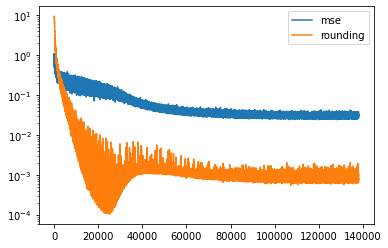

In [11]:
plt.plot(loss_terms_dict['mse'], label='mse')
plt.plot(loss_terms_dict['rounding'], label='rounding')
plt.legend()
plt.yscale('log')

In [16]:
torch.save(diffusion_model.state_dict(), "checkpoints/roc_unshared_dim128_embnoise.pth")

In [12]:
x_T = torch.randn(size=(batch_size, max_len, word_embedding_dim))

In [13]:
logits, hidden_states = diffusion_model.sample(x_T.to(device), return_hidden_states=True, verbose=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [14]:
sample_idx = 0
for step in [0,1500,1800,1900,1950,1980,1990,1995,1996,1997,1998,1999]:
    hidden_state = hidden_states[step][sample_idx]
    with torch.no_grad():
        hidden_logits = diffusion_model.lm_head(hidden_state)
        sampled_ids = torch.argmax(hidden_logits,dim=-1).cpu()
        sampled_seq = [rev_tokenizer[token_id.item()] for token_id in sampled_ids]
        print("step:", step)
        print(" ".join(sampled_seq))

step: 0
lessons [UNK] Bobby laying grew teacher . brother children roommate threw his fan calm and videos hurt everything bags It at arrived thought beginning close worth York It friends Unfortunately came became order lots and shirt contest Jenny that do pass bathroom . never day city . purchase showed After full go . in had an stove to each and an to run very Two Alice home a his room brother of
step: 1500
puppy dinner moving of , and to Then But my would single 's sunny offered amazed big of Tina got friends so haircut mall burned went really driving However she would proudly n't an month several be how for hour road very . [END] lost her the [PAD] a [PAD] found got [PAD] [PAD] found every [PAD] got each got [PAD] challenged not to [PAD] would that tried all [PAD] all bar
step: 1800
[START] account this mother being bottle instead She put my her getting . watched . woman we vet it a There so been had down love for put and friends would decided to all few No broke they . fence stage 

In [15]:
for sample_idx in range(32):
    hidden_state = hidden_states[-1][sample_idx]
    with torch.no_grad():
        hidden_logits = diffusion_model.lm_head(hidden_state)
        sampled_ids = torch.argmax(hidden_logits,dim=-1).cpu()
        sampled_seq = [rev_tokenizer[token_id.item()] for token_id in sampled_ids]
        print("sample_idx:", sample_idx)
        print(" ".join(sampled_seq))

sample_idx: 0
[START] for ordered his friends , high . apartment the out his first house . Tom have dogs asked a table and done a get . He agreed friends much up it a band the head to his of was she would . [END] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
sample_idx: 1
[START] The girls cat cat who , son his His next class . was Thanksgiving to horse about [UNK] on his playing noise . They was mother started summer . friends the like . His work and until set his the next day . . The of [UNK] and the day of the a new both next . [END] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
sample_idx: 2
[START] A wife the . wanted to [UNK] . She was party moved to take , day . She decided to mom her . up on into and finally , too . The would a would and the [UNK] more . [END] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

In [17]:
logits, hidden_states = diffusion_model.sample(x_T.to(device),clamp='rounding', return_hidden_states=True, verbose=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [18]:
for sample_idx in range(32):
    hidden_state = hidden_states[-1][sample_idx]
    with torch.no_grad():
        hidden_logits = diffusion_model.lm_head(hidden_state)
        sampled_ids = torch.argmax(hidden_logits,dim=-1).cpu()
        sampled_seq = [rev_tokenizer[token_id.item()] for token_id in sampled_ids]
        print("sample_idx:", sample_idx)
        print(" ".join(sampled_seq))

sample_idx: 0
[START] I wanted of friend Jenny . They to a . . . Then I picked and to to . One was able . Tom class to a the . He decided to [UNK] to not it and the . [END] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
sample_idx: 1
[START] Tom and a took to for in test . a decided an the box called [UNK] [UNK] was . to the food it his morning . . She bought the [UNK] . The the a the . [END] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
sample_idx: 2
[START] Today was n't for on her friends a . told thought in a to . she . to did n't children had . He were to a sick . His [UNK] , . She the date new . night the the of wait friends to an up to and not and the his . [END] [PAD] [PAD] [PAD] [PAD] [PAD] 

In [30]:
diffusion_model.word_embeddings.weight.data

tensor([[-0.4805,  0.3161,  1.1531,  ...,  1.6092,  0.0171, -0.0755],
        [ 0.5296, -0.2127,  0.8692,  ..., -1.3619,  0.0922,  0.2312],
        [-0.5909, -0.2637, -0.1425,  ...,  0.2933, -0.0284,  0.2060],
        ...,
        [-0.0487, -0.1270, -0.7429,  ..., -0.4486, -0.2888,  0.6939],
        [-0.0635,  0.0507, -0.6597,  ..., -0.0198,  0.6503,  1.5029],
        [ 0.2038, -0.0694,  0.1111,  ...,  1.4222, -0.0120, -0.0297]],
       device='cuda:1')

In [23]:
diffusion_model.lm_head.weight.data

tensor([[-0.4805,  0.3161,  1.1531,  ...,  1.6092,  0.0171, -0.0755],
        [ 0.5296, -0.2127,  0.8692,  ..., -1.3619,  0.0922,  0.2312],
        [-0.5909, -0.2637, -0.1425,  ...,  0.2933, -0.0284,  0.2060],
        ...,
        [-0.0487, -0.1270, -0.7429,  ..., -0.4486, -0.2888,  0.6939],
        [-0.0635,  0.0507, -0.6597,  ..., -0.0198,  0.6503,  1.5029],
        [ 0.2038, -0.0694,  0.1111,  ...,  1.4222, -0.0120, -0.0297]],
       device='cuda:1')

In [25]:
diffusion_model.lm_head.bias

Parameter containing:
tensor([-2.8335e+00,  5.0157e-01,  1.5772e+00,  1.6008e+00,  1.3920e+00,
        -5.0213e-01,  6.7412e-01,  1.5496e+00,  1.5888e+00, -1.4500e+00,
         5.5731e-02,  1.8086e+00,  4.3691e-01, -4.1515e-01,  1.5522e+00,
         1.0511e+00,  1.1348e+00, -1.7812e+00, -2.4732e+00,  1.0588e-01,
         9.5429e-01,  5.0374e-01, -1.8397e+00,  1.2936e+00, -8.1339e-01,
         1.4371e+00,  2.4678e-01, -4.5192e-02,  5.2514e-01, -1.9127e+00,
         9.4692e-01,  1.6614e+00,  1.1508e+00,  1.1107e+00,  7.1305e-01,
        -1.9485e+00,  1.5000e+00, -5.3676e-01,  2.8657e+00,  1.0546e+00,
         1.1212e+00,  1.6808e+00,  1.0841e+00, -8.2300e-01, -3.2293e-01,
         6.3604e-01,  2.0501e+00,  1.4522e+00,  1.5419e+00,  2.6134e+00,
         6.9575e-01,  1.0382e+00,  9.5937e-01,  1.4109e+00,  5.3004e-01,
        -9.3019e-01,  2.7558e-01, -1.3236e+00,  5.6241e-01, -6.0610e-01,
         1.2124e+00,  1.5894e+00, -1.8690e+00, -8.2687e-01,  2.2712e+00,
         2.2624e-01, -1.3299e

In [21]:
diffusion_model.word_embeddings.weight.data.shape

torch.Size([11831, 128])

In [26]:
torch.norm(diffusion_model.word_embeddings.weight.data,dim=1,keepdim=True).shape

torch.Size([11831, 1])

In [27]:
logits.shape

torch.Size([32, 72, 11831])

In [28]:
hidden_states[-1].shape

torch.Size([32, 72, 128])

In [31]:
with torch.no_grad():
    normed_emb = diffusion_model.word_embeddings.weight.data/torch.norm(diffusion_model.word_embeddings.weight.data,dim=1,keepdim=True)
    sim = torch.matmul(hidden_states[-1], normed_emb.T)

In [32]:
sim.shape

torch.Size([32, 72, 11831])

In [34]:
torch.argmax(sim[0],dim=-1)==torch.argmax(logits[0],dim=-1)

tensor([ True,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True], device='cuda:1')

In [37]:
print(hidden_states[-1].shape)
print(diffusion_model.word_embeddings.weight.data.T.shape)

torch.Size([32, 72, 128])
torch.Size([128, 11831])


In [38]:
with torch.no_grad():
    dist = torch.dist(hidden_states[-1].unsqueeze(-1), diffusion_model.word_embeddings.weight.data.T)

In [48]:
with torch.no_grad():
    l2_dist = torch.sum((hidden_states[-1].cpu().unsqueeze(-1)-diffusion_model.word_embeddings.weight.data.T.cpu())**2,dim=2)

In [50]:
l2_dist.shape

torch.Size([32, 72, 11831])

In [52]:
torch.argmin(l2_dist[0],dim=-1)==torch.argmax(logits[0].cpu(),dim=-1)

tensor([ True,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True])

In [26]:
with torch.no_grad():
    for data in eval_dataloader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        loss_terms = diffusion_model(input_ids, attention_mask)
        break

In [29]:
for key, val in loss_terms.items():
    print(key,loss_terms[key].mean())

mse tensor(0.0490, device='cuda:1')
L_T tensor(6.3241e-08, device='cuda:1')
rounding tensor(0.0051, device='cuda:1')


In [27]:
learned_embbeding = diffusion_model.word_embeddings.weight.data.cpu()

In [28]:
learned_rounding = diffusion_model.lm_head.weight.data.cpu()

In [42]:
test_input_ids = torch.LongTensor(range(config.vocab_size))

In [43]:
with torch.no_grad():
    emb = diffusion_model.word_embeddings(test_input_ids.to(device))
    rounded = diffusion_model.lm_head(emb)
    print(rounded.shape)

torch.Size([852, 852])


In [49]:
(torch.argmax(rounded,dim=1).cpu()==test_input_ids).sum()

tensor(852)